<a href="https://colab.research.google.com/github/AchrafAsh/deepfakes/blob/main/dalle_deepfake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install DALL-E
#!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.8 MB/s eta 0:00:00


In [ ]:
import io
import os, sys
import requests
import PIL

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from dall_e import map_pixels, unmap_pixels, load_model
from IPython.display import display, display_markdown

In [ ]:
target_image_size = 256

In [ ]:
def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return PIL.Image.open(io.BytesIO(resp.content))

def preprocess(img):
    s = min(img.size)
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return map_pixels(img)

In [ ]:
# This can be changed to a GPU, e.g. 'cuda:0'.
device = torch.device('cuda')
encoder = load_model("https://cdn.openai.com/dall-e/encoder.pkl", device)
decoder = load_model("https://cdn.openai.com/dall-e/decoder.pkl", device)

In [ ]:
# Patch for torch 1.11 and higher: replace the old Upsample object by the new version
# that exposes recompute_scale_factor
old_upsample = decoder.blocks.group_1.upsample
decoder.blocks.group_1.upsample = torch.nn.Upsample(
    scale_factor=old_upsample.scale_factor,
    mode=old_upsample.mode
)

old_upsample_2 = decoder.blocks.group_2.upsample
decoder.blocks.group_2.upsample = torch.nn.Upsample(
    scale_factor=old_upsample_2.scale_factor,
    mode=old_upsample_2.mode
)

old_upsample_3 = decoder.blocks.group_3.upsample
decoder.blocks.group_3.upsample = torch.nn.Upsample(
    scale_factor=old_upsample_3.scale_factor,
    mode=old_upsample_3.mode
)

In [ ]:
!unzip dalle_dataset

Archive:  dalle_dataset.zip
   creating: dalle_dataset/
  inflating: __MACOSX/._dalle_dataset  
   creating: dalle_dataset/caillet/
  inflating: __MACOSX/dalle_dataset/._caillet  
  inflating: dalle_dataset/.DS_Store  
  inflating: __MACOSX/dalle_dataset/._.DS_Store  
   creating: dalle_dataset/cruise/
  inflating: dalle_dataset/caillet/002.png  
  inflating: __MACOSX/dalle_dataset/caillet/._002.png  
  inflating: dalle_dataset/caillet/003.png  
  inflating: __MACOSX/dalle_dataset/caillet/._003.png  
  inflating: dalle_dataset/caillet/001.png  
  inflating: __MACOSX/dalle_dataset/caillet/._001.png  
  inflating: dalle_dataset/caillet/010.png  
  inflating: __MACOSX/dalle_dataset/caillet/._010.png  
  inflating: dalle_dataset/caillet/004.png  
  inflating: __MACOSX/dalle_dataset/caillet/._004.png  
  inflating: dalle_dataset/caillet/005.png  
  inflating: __MACOSX/dalle_dataset/caillet/._005.png  
  inflating: dalle_dataset/caillet/011.png  
  inflating: __MACOSX/dalle_dataset/caillet/.

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


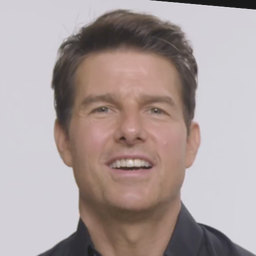

In [ ]:
# x = preprocess(download_image('https://assets.bwbx.io/images/users/iqjWHBFdfxIU/iKIWgaiJUtss/v2/1000x-1.jpg'))
x = preprocess(PIL.Image.open('./dalle_dataset/cruise/001.png'))
display_markdown('Original image:')
display(T.ToPILImage(mode='RGB')(x[0]))

x.size() torch.Size([1, 3, 256, 256]) z_logits.size() torch.Size([1, 8192, 32, 32]) z.size() torch.Size([1, 32, 32])


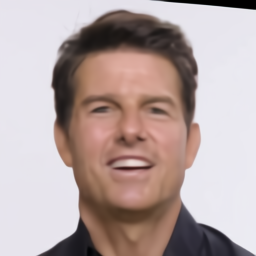

In [ ]:
x = x.to(device)
z_logits = encoder(x)

z = torch.argmax(z_logits, axis=1)
print('x.size()',x.size(),'z_logits.size()',z_logits.size(),'z.size()',z.size())
z = F.one_hot(z, num_classes=encoder.vocab_size).permute(0, 3, 1, 2).float()

x_stats = decoder(z).float()
x_rec = unmap_pixels(torch.sigmoid(x_stats[:, :3]))
x_rec = T.ToPILImage(mode='RGB')(x_rec[0])

display_markdown('Reconstructed image:')
display(x_rec)

## Training the decoder

In [ ]:
import torch
from torch import nn
from torchvision.models.vgg import vgg16

In [ ]:
class GeneratorLoss(nn.Module):
    def __init__(self):
        super(GeneratorLoss, self).__init__()
        vgg = vgg16(pretrained=True)
        loss_network = nn.Sequential(*list(vgg.features)[:31]).eval()
        for param in loss_network.parameters():
            param.requires_grad = False
        self.loss_network = loss_network
        self.mse_loss = nn.MSELoss()
        self.tv_loss = TVLoss()

    def forward(self, fake_img, real_img):
        # Perception Loss
        perception_loss = self.mse_loss(self.loss_network(fake_img), self.loss_network(real_img))
        # Image Loss
        image_loss = self.mse_loss(fake_img, real_img)
        # TV Loss
        tv_loss = self.tv_loss(fake_img)
        return image_loss + 0.006 * perception_loss + 2e-8 * tv_loss


class TVLoss(nn.Module):
    def __init__(self, tv_loss_weight=1):
        super(TVLoss, self).__init__()
        self.tv_loss_weight = tv_loss_weight

    def forward(self, x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h = self.tensor_size(x[:, :, 1:, :])
        count_w = self.tensor_size(x[:, :, :, 1:])
        h_tv = torch.pow((x[:, :, 1:, :] - x[:, :, :h_x - 1, :]), 2).sum()
        w_tv = torch.pow((x[:, :, :, 1:] - x[:, :, :, :w_x - 1]), 2).sum()
        return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

    @staticmethod
    def tensor_size(t):
        return t.size()[1] * t.size()[2] * t.size()[3]

In [ ]:
encoder.eval()
decoder.train()

Decoder(
  (blocks): Sequential(
    (input): Conv2d(n_in=8192, n_out=128, kw=1, use_float16=False, device=device(type='cpu'), requires_grad=False)
    (group_1): Sequential(
      (block_1): DecoderBlock(
        (id_path): Conv2d(n_in=128, n_out=2048, kw=1, use_float16=True, device=device(type='cpu'), requires_grad=False)
        (res_path): Sequential(
          (relu_1): ReLU()
          (conv_1): Conv2d(n_in=128, n_out=512, kw=1, use_float16=True, device=device(type='cpu'), requires_grad=False)
          (relu_2): ReLU()
          (conv_2): Conv2d(n_in=512, n_out=512, kw=3, use_float16=True, device=device(type='cpu'), requires_grad=False)
          (relu_3): ReLU()
          (conv_3): Conv2d(n_in=512, n_out=512, kw=3, use_float16=True, device=device(type='cpu'), requires_grad=False)
          (relu_4): ReLU()
          (conv_4): Conv2d(n_in=512, n_out=2048, kw=3, use_float16=True, device=device(type='cpu'), requires_grad=False)
        )
      )
      (block_2): DecoderBlock(
    

In [ ]:
optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-6)
criterion = GeneratorLoss().to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
num_epochs = 1_000

for epoch in range(num_epochs):
    total_loss = 0
    
    for i in range(9):
        path = f"./dalle_dataset/cruise/00{i+1}.png"
        real_A = preprocess(PIL.Image.open(path)).to(device)
        z_logits = encoder(real_A)
        z = z_logits.argmax(1)
        z = F.one_hot(z, num_classes=encoder.vocab_size).permute(0, 3, 1, 2).float()
        fake_A = unmap_pixels(torch.sigmoid(decoder(z).float()[:, :3]))

        optimizer.zero_grad()
        loss = criterion(fake_A, real_A)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if (epoch+1) % 10 == 0:
        print(f"[{epoch+1}/{num_epochs}] Loss: {total_loss}")

### Test

Real Image

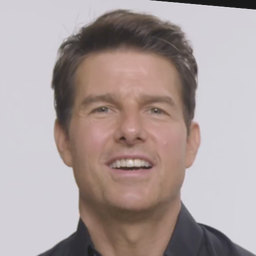

In [ ]:
x = preprocess(PIL.Image.open('./dalle_dataset/cruise/001.png'))[:,:3,:,:]
display_markdown('Original image:')
display(T.ToPILImage(mode='RGB')(x[0]))

Reconstructed Image

x.size() torch.Size([1, 3, 256, 256]) z_logits.size() torch.Size([1, 8192, 32, 32]) z.size() torch.Size([1, 32, 32])


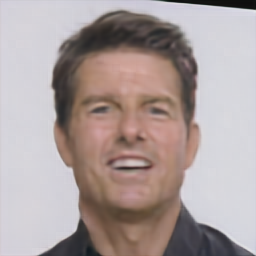

In [ ]:
x = x.to(device)
z_logits = encoder(x)

z = torch.argmax(z_logits, axis=1)
print('x.size()',x.size(),'z_logits.size()',z_logits.size(),'z.size()',z.size())
z = F.one_hot(z, num_classes=encoder.vocab_size).permute(0, 3, 1, 2).float()

x_stats = decoder(z).float()
x_rec = unmap_pixels(torch.sigmoid(x_stats[:, :3]))
x_rec = T.ToPILImage(mode='RGB')(x_rec[0])

display_markdown('Reconstructed image:')
display(x_rec)

Deep Fake

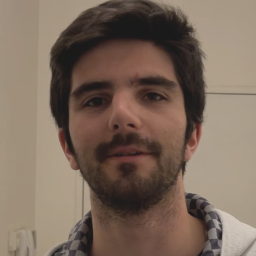

In [ ]:
x = preprocess(PIL.Image.open('./dalle_dataset/caillet/001.png'))[:,:3,:,:]
display_markdown('Original image:')
display(T.ToPILImage(mode='RGB')(x[0]))

x.size() torch.Size([1, 3, 256, 256]) z_logits.size() torch.Size([1, 8192, 32, 32]) z.size() torch.Size([1, 32, 32])


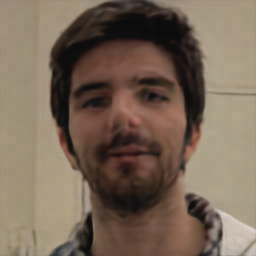

In [ ]:
x = x.to(device)
z_logits = encoder(x)

z = torch.argmax(z_logits, axis=1)
print('x.size()',x.size(),'z_logits.size()',z_logits.size(),'z.size()',z.size())
z = F.one_hot(z, num_classes=encoder.vocab_size).permute(0, 3, 1, 2).float()

x_stats = decoder(z).float()
x_rec = unmap_pixels(torch.sigmoid(x_stats[:, :3]))
x_rec = T.ToPILImage(mode='RGB')(x_rec[0])

display_markdown('Reconstructed image:')
display(x_rec)